In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

In [2]:
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

C:\Users\Pradneya Prabhudesai\AppData\Local\Temp\ipykernel_20100\1763590552.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  tags = pd.read_csv('data/tags.csv')


In [3]:
# Spliting the genres column into multiple columns and encoding them
movies['genres'] = movies['genres'].str.split('|')
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies = movies.join(genres_df)

In [4]:
# Convert the timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['timestamp'].dt.year

In [5]:
# Normalize the ratings
scaler = MinMaxScaler()
ratings['rating_normalized'] = scaler.fit_transform(ratings['rating'].values.reshape(-1, 1))

In [6]:
# Filter out movies with less than 5 ratings
min_movie_ratings = 5
movie_counts = ratings['movieId'].value_counts()
ratings = ratings[ratings['movieId'].isin(movie_counts[movie_counts >= min_movie_ratings].index)]

In [7]:
print("Ratings Dataframe Details")
print(ratings.shape)
print(ratings.info())

Ratings Dataframe Details
(31921467, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 31921467 entries, 0 to 32000203
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   userId             int64         
 1   movieId            int64         
 2   rating             float64       
 3   timestamp          datetime64[ns]
 4   year               int32         
 5   rating_normalized  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2)
memory usage: 1.5 GB
None


In [8]:
print("Movies Dataframe Details")
print(movies.shape)
print(movies.info())

Movies Dataframe Details
(87585, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieId             87585 non-null  int64 
 1   title               87585 non-null  object
 2   genres              87585 non-null  object
 3   (no genres listed)  87585 non-null  int32 
 4   Action              87585 non-null  int32 
 5   Adventure           87585 non-null  int32 
 6   Animation           87585 non-null  int32 
 7   Children            87585 non-null  int32 
 8   Comedy              87585 non-null  int32 
 9   Crime               87585 non-null  int32 
 10  Documentary         87585 non-null  int32 
 11  Drama               87585 non-null  int32 
 12  Fantasy             87585 non-null  int32 
 13  Film-Noir           87585 non-null  int32 
 14  Horror              87585 non-null  int32 
 15  IMAX                87585 non-nul

In [9]:
counts = ratings['movieId'].value_counts()
counts

movieId
318       102929
356       100296
296        98409
2571       93808
593        90330
           ...  
278208         5
153782         5
177535         5
176811         5
175275         5
Name: count, Length: 43884, dtype: int64

In [10]:
# user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
# user_item_matrix 

from scipy.sparse import coo_matrix

# Create the user-item matrix using sparse format
user_item_matrix_sparse = coo_matrix((ratings['rating'], (ratings['userId'], ratings['movieId'])))


In [11]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)


In [12]:
from surprise import Dataset, Reader, SVD
from surprise import accuracy

# Define the reader for the dataset
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))

# Load the train and test data
train_data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader).build_full_trainset()
test_data = list(zip(test['userId'], test['movieId'], test['rating']))


In [13]:
# Initialize and train the SVD model
svd = SVD()
svd.fit(train_data)

In [14]:
# Make predictions on the test set
predictions = [svd.predict(uid=row[0], iid=row[1], r_ui=row[2]) for row in test_data]

# Calculate RMSE without reusing the name
test_rmse = accuracy.rmse(predictions, verbose=True)
print(f"Test RMSE: {test_rmse}")

RMSE: 0.7715
Test RMSE: 0.7715218687761134


In [18]:
def recommend_movies(user_id, svd, movies, ratings, top_n=10):
    # Get all movie IDs
    all_movies = set(movies['movieId'])
    
    # Get movies already rated by the user
    rated_movies = set(ratings[ratings['userId'] == user_id]['movieId'])
    
    # Predict ratings for unseen movies
    unseen_movies = all_movies - rated_movies
    predictions = [(movie, svd.predict(user_id, movie).est) for movie in unseen_movies]
    
    # Sort movies by predicted rating
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Map back to movie titles
    recommended_movie_titles = [movies[movies['movieId'] == movie].iloc[0]['title'] for movie, _ in recommendations]
    return recommended_movie_titles

# Example usage
user_id = 1554
top_movies = recommend_movies(user_id, svd, movies, ratings, top_n=10)
print(f"Top recommended movies for User {user_id}:")
for movie in top_movies:
    print(movie)


Top recommended movies for User 1554:
Blade Runner (1982)
Godfather, The (1972)
Citizen Kane (1941)
Princess Mononoke (Mononoke-hime) (1997)
Spirited Away (Sen to Chihiro no kamikakushi) (2001)
Welfare (1975)
Twelve Angry Men (1954)
Fishing with John (1991)
My Neighbor Totoro (Tonari no Totoro) (1988)
Seven Samurai (Shichinin no samurai) (1954)


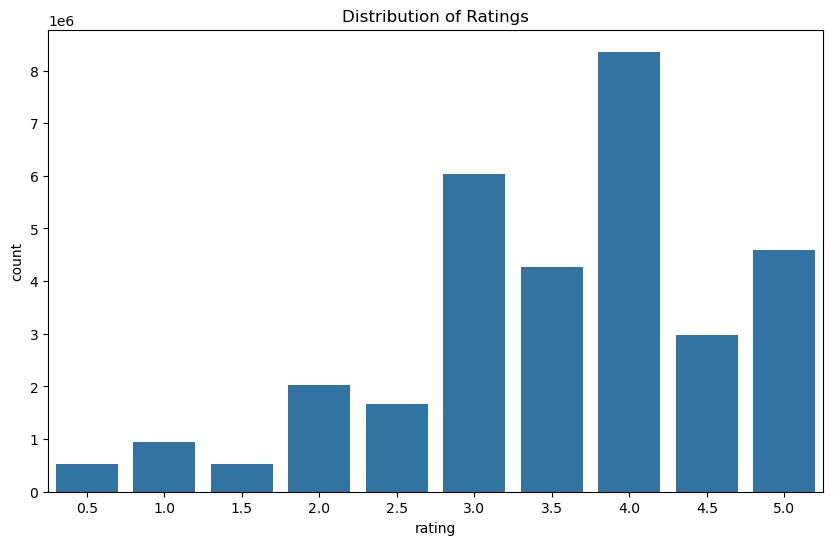

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

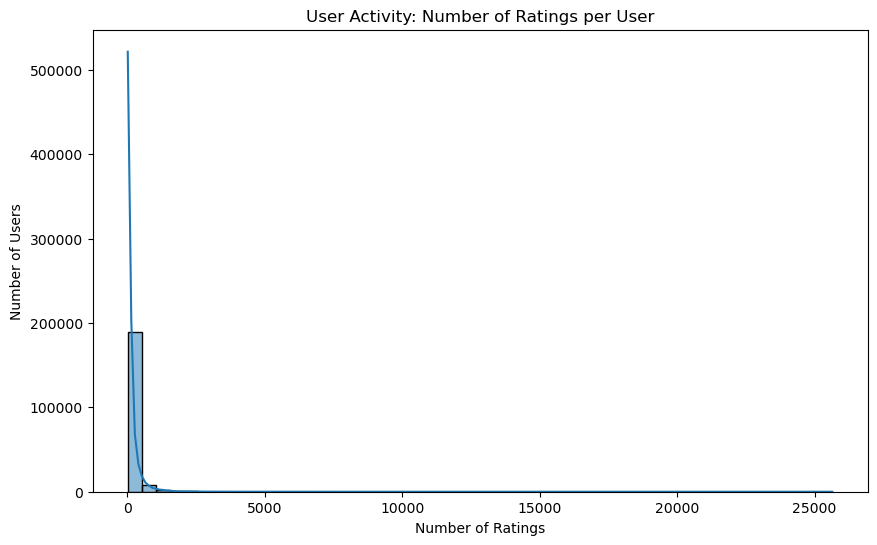

In [17]:
user_activity = ratings.groupby('userId').size()
plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=50, kde=True)
plt.title('User Activity: Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()